# Segment a point cloud using a shapefile

In [15]:
import numpy as np 
import matplotlib.pyplot as plt


import cloudComPy as cc # cloud compare python interface.
if cc.isPluginCanupo():
    import cloudComPy.Canupo

if cc.isPluginPCL():
    import cloudComPy.PCL
from osgeo import gdal, ogr, osr
from subprocess import run

import json
import os 
from yaml import load
from yaml.loader import Loader

from helpers.utils import plot_segmentation_scheme

In [16]:
caveName = "01_VersChezLeBrandt"
root = f"../../real_data/{caveName}"


PROCESSING_FILEPATH = os.path.join(root, "params.yaml")

p = load(open(PROCESSING_FILEPATH), Loader)

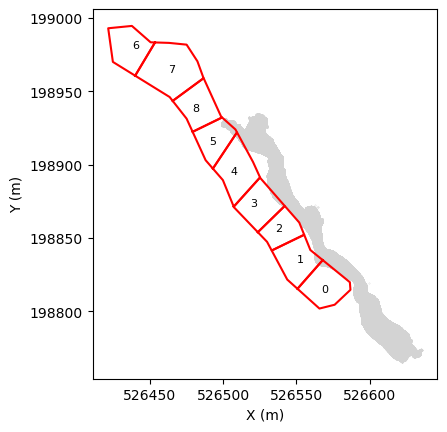

In [17]:
fig, ax = plt.subplots()

ax, res = plot_segmentation_scheme(root, ax)
plt.xlabel("X (m)")
plt.ylabel("Y (m)")

plt.show()

In [ ]:
cloud = cc.loadPointCloud(f"../../real_data/{caveName}/output/{caveName}_Cut2D.ply",  cc.CC_SHIFT_MODE.XYZ, 0, *shift)

In [ ]:
cloud.size()

In [ ]:
polyline_3 = cc_polylines[2]

CloudCropZ = cloud.crop2D(cc_polylines[3], 2, True)

In [ ]:
CloudCropZ.size()

In [ ]:
print(f"../../real_data/{caveName}/process/Cropped_3.ply")

In [ ]:
ret = cc.SavePointCloud(CloudCropZ, f"../../real_data/{caveName}/process/Cropped_3.ply")

In [ ]:
# cycle through each polyline and cut the cloud, then save to a new ply file.  
for c, polyline in enumerate(cc_polylines): 

    # crop the cloud using the polyline, only leave stuff inside. 
    CloudCropZ = cloud.crop2D(polyline, 2, True) # 2 means that the viewing direction is parallel to Z axis and cropping is done from top view accordingly. 
    ret = cc.SavePointCloud(CloudCropZ, f"../../real_data/{caveName}/process/Cropped_{c}.ply")
